In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

/home/giles/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/giles/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/giles/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#torch.cuda.set_device(2)

In [4]:
torch.backends.cudnn.benchmark=True

## Data

In [5]:
PATH = Path('/home/giles/Downloads/fastai_data/salt/')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [7]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [8]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [9]:
(PATH/'train-128').mkdir(exist_ok=True)

In [10]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [11]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 32
bs = 64
nw = 16

TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 128
bs = 64
nw = 16

In [12]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [13]:
x_names = np.array(glob(f'{PATH}/{TRAIN_DN}/*'))
y_names = np.array(glob(f'{PATH}/{MASKS_DN}/*'))

In [14]:
val_idxs = list(range(800))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [15]:
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

In [16]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [17]:
x,y = next(iter(md.trn_dl))

In [18]:
x.shape,y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 32, 32]))

In [19]:
denorm = md.val_ds.denorm

In [20]:
def show_aug_img(ims, idx, figsize=(5,5), normed=True, ax=None, nchannels=3):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else:      ims = np.rollaxis(to_np(ims),1,nchannels+1)
    ax.imshow(np.clip(ims,0,1)[idx])
    ax.axis('off')

In [21]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

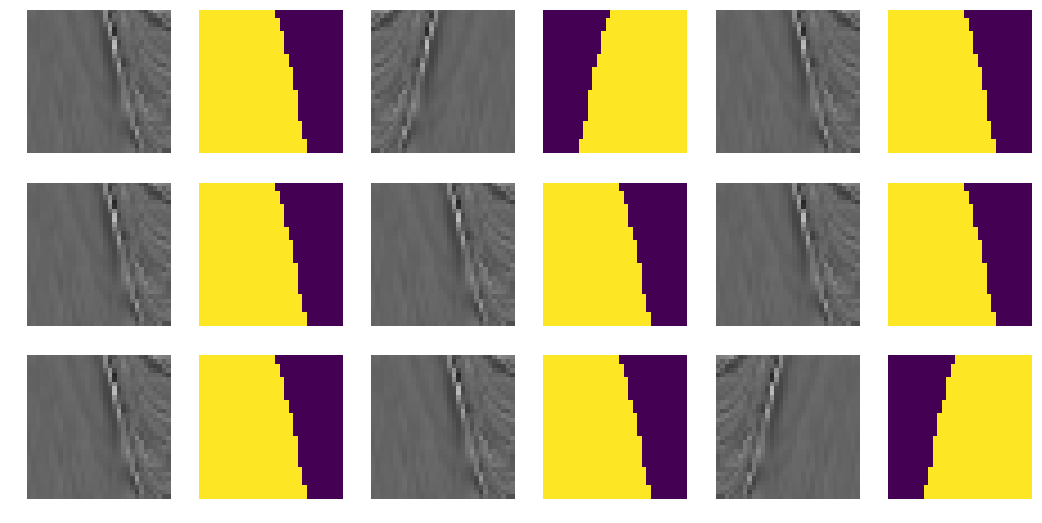

In [22]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_aug_img(x,1, ax=axes.flat[i*2])
    show_aug_img(y,1, ax=axes.flat[i*2+1], nchannels=1, normed=False)

## Simple upsample

In [23]:
f = resnext50
cut,lr_cut = model_meta[f]

In [24]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [25]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## U-net (ish)

In [26]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [27]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [28]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(2048,1024,256)
        self.up2 = UnetBlock(256,512,256)
        self.up3 = UnetBlock(256,256,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [29]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [30]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [31]:
from torch.nn.modules.loss import _Loss
from torch.nn.modules import Module
from torch.nn import functional as F

class BCEWithLogitsLossAndDice(Module):
    def __init__(self, weight=None, size_average=True):
        super(BCEWithLogitsLossAndDice, self).__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)

    def forward(self, input, target):
        if self.weight is not None:
            return F.binary_cross_entropy_with_logits(input, target, Variable(self.weight), self.size_average)+(2*(1-dice(input, target)))
        else:
            return F.binary_cross_entropy_with_logits(input, target, size_average=self.size_average)+(2*(1-dice(input, target)))

In [32]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=BCEWithLogitsLossAndDice()
learn.metrics=[accuracy_thresh(0.5),dice]

In [33]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
                           ('output_shape', [-1, 64, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 8, 8]),
            

In [34]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 16, 16]),
 torch.Size([3, 256, 8, 8]),
 torch.Size([3, 512, 4, 4]),
 torch.Size([3, 1024, 2, 2])]

In [35]:
learn.freeze_to(1)

 86%|████████▌ | 43/50 [00:03<00:00, 12.77it/s, loss=1.51]


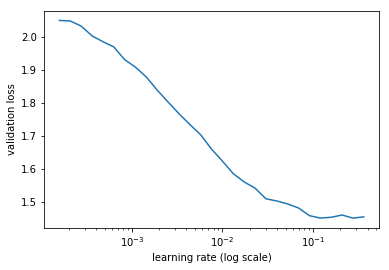

In [36]:
learn.lr_find()
learn.sched.plot()

In [37]:
lr=5e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [38]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.84451    1.538007   0.833739   0.718378  
    1      0.742104   0.770143   0.885387   0.77339        
    2      0.667175   0.670964   0.892963   0.78554        
    3      0.60331    0.566671   0.914205   0.826668       
    4      0.554693   0.551123   0.914084   0.827497       
    5      0.510381   0.568115   0.917719   0.829301       
    6      0.463762   0.535275   0.920321   0.83787        
    7      0.414964   0.501863   0.924608   0.849245       



[array([0.50186]), 0.924608154296875, 0.8492452371936905]

In [39]:
learn.save('32urn-tmp')

In [40]:
learn.load('32urn-tmp')

In [41]:
learn.unfreeze()
learn.bn_freeze(True)

In [42]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.323778   0.516217   0.925204   0.846554  
    1      0.3764     0.523206   0.924458   0.847009       
    2      0.350242   0.51889    0.928605   0.853817       
    3      0.309277   0.501666   0.928743   0.857762       
    4      0.283155   0.481062   0.932367   0.863871       
    5      0.41152    0.523772   0.925082   0.850065       
    6      0.335621   0.505014   0.927855   0.8544         
    7      0.27359    0.503645   0.930435   0.858843       
    8      0.244609   0.500152   0.932386   0.862175       
    9      0.220835   0.462654   0.935815   0.87257        
    10     0.201067   0.495709   0.934325   0.868618       
    11     0.192167   0.507459   0.932966   0.864541       
    12     0.180067   0.503303   0.93375    0.866502       
    13     0.172853   0.489848   0.935223   0.871173       
    14     0.168967   0.499313   0.935275   0.870631       
    15     0.162891   0.504092   0.935189   0

[array([0.51203]), 0.936544189453125, 0.8727956725817405]

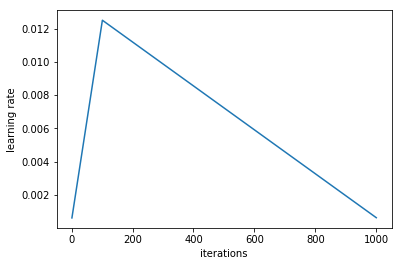

In [43]:
learn.sched.plot_lr()

In [44]:
learn.save('32urn-0')

In [45]:
learn.load('32urn-0')

In [46]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

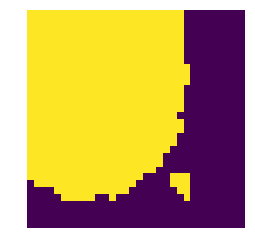

In [47]:
show_img(py[0]>0.5);

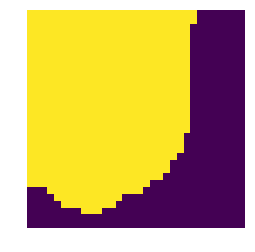

In [48]:
show_img(y[0]);

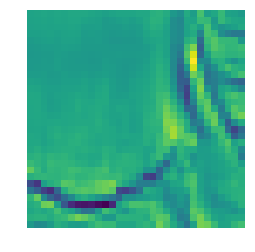

In [49]:
show_img(x[0][0]);

In [50]:
m.close()

## 64x64

In [51]:
sz=64
bs=64

In [52]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [53]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [54]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=BCEWithLogitsLossAndDice()
learn.metrics=[accuracy_thresh(0.5),dice]

In [55]:
learn.freeze_to(1)

In [56]:
learn.load('32urn-0')

In [58]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.505889   1.33911    0.854069   0.745107  
    1      0.482244   0.523997   0.928452   0.848919       
    2      0.426535   0.487823   0.925313   0.848918       
    3      0.379633   0.467608   0.92914    0.859637       
    4      0.331852   0.445533   0.935355   0.865846       



[array([0.44553]), 0.935355224609375, 0.8658463600855911]

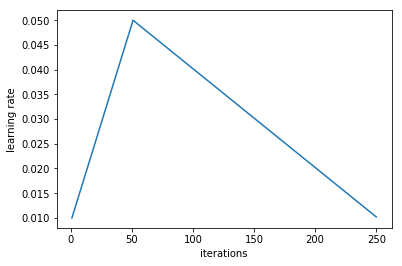

In [59]:
learn.sched.plot_lr()

In [60]:
learn.save('64urn-tmp')

In [61]:
learn.unfreeze()
learn.bn_freeze(True)

In [62]:
learn.load('64urn-tmp')

In [63]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.273809   0.429102   0.940001   0.875179  
    1      0.269654   0.454335   0.938937   0.872293       
    2      0.243652   0.422143   0.940122   0.875666       
    3      0.239226   0.391966   0.944111   0.887862       
    4      0.205829   0.389085   0.945715   0.890639       
    5      0.181466   0.429036   0.943425   0.886658       
    6      0.165176   0.429073   0.943615   0.885221       
    7      0.152053   0.394617   0.947626   0.893889       



[array([0.39462]), 0.9476260375976563, 0.8938885616233737]

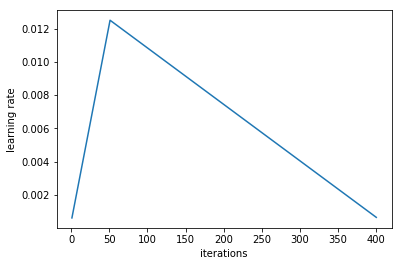

In [64]:
learn.sched.plot_lr()

In [65]:
learn.save('64urn')

In [66]:
learn.load('64urn')

In [67]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

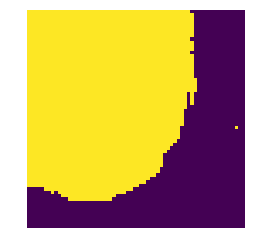

In [68]:
show_img(py[0]>0.5);

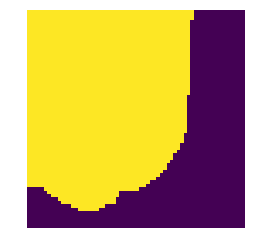

In [69]:
show_img(y[0]);

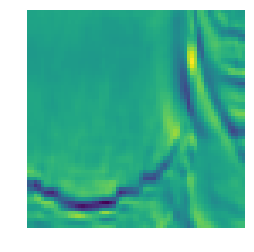

In [70]:
show_img(x[0][0]);

In [71]:
m.close()

## 128x128

In [47]:
sz=128
bs=64

In [48]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [74]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [75]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=BCEWithLogitsLossAndDice()
learn.metrics=[accuracy_thresh(0.5),dice]

 90%|█████████ | 45/50 [00:08<00:00,  5.28it/s, loss=2.4]  


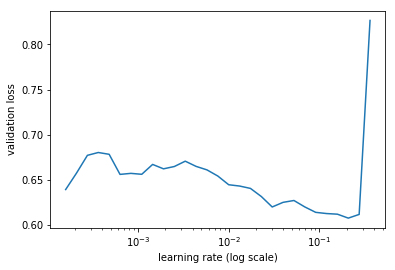

In [76]:
learn.load('64urn')
learn.freeze_to(1)
learn.lr_find()
learn.sched.plot()

In [77]:
learn.fit(lr,1, wds=wd, cycle_len=3,use_clr=(3,2))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.487862   0.681145   0.900018   0.790265  
    1      0.487031   0.430776   0.9377     0.872646       
    2      0.426984   0.389388   0.938699   0.8802         



[array([0.38939]), 0.9386988830566406, 0.880199974810924]

In [78]:
learn.save('128urn-tmp')

In [79]:
learn.load('128urn-tmp')

In [80]:
learn.unfreeze()
learn.bn_freeze(True)

In [81]:
lrs = np.array([lr/200,lr/30,lr])

In [82]:
wd

1e-07

In [83]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.308707   0.356856   0.943785   0.890543  
    1      0.300357   0.352418   0.946751   0.895043       
    2      0.292783   0.352804   0.948057   0.89546        
    3      0.283714   0.346172   0.9478     0.896818       



[array([0.34617]), 0.9477996826171875, 0.8968177894430615]

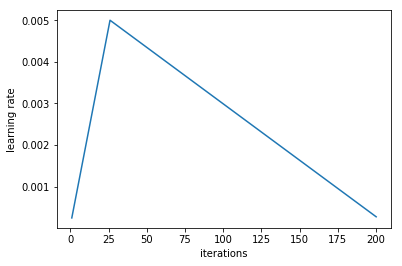

In [84]:
learn.sched.plot_lr()

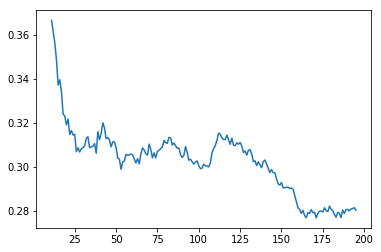

In [85]:
learn.sched.plot_loss()

In [86]:
learn.save('128urn')

In [87]:
learn.load('128urn')

In [49]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

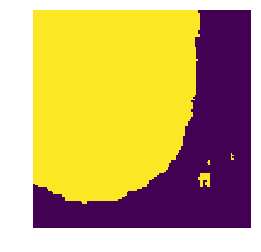

In [50]:
show_img(py[0]>0.5);

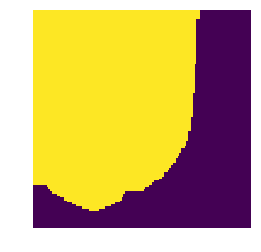

In [51]:
show_img(y[0]);

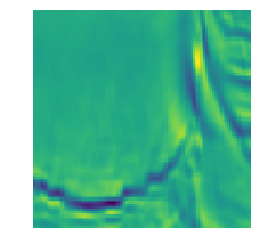

In [52]:
show_img(x[0][0]);

In [53]:
y.shape

torch.Size([64, 128, 128])

In [54]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

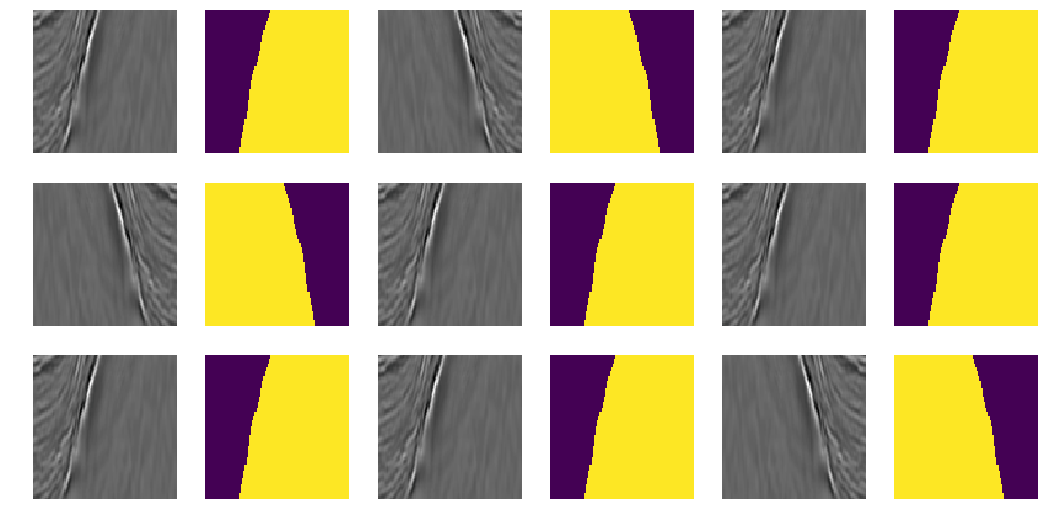

In [55]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_aug_img(x,1, ax=axes.flat[i*2])
    show_aug_img(y,1, ax=axes.flat[i*2+1], nchannels=1, normed=False)

# Test on original validation

In [113]:
x_names_orig = np.array(glob(f'{PATH}/train/*'))
y_names_orig = np.array(glob(f'{PATH}/train_masks/*'))

In [114]:
val_idxs_orig = list(range(800))
((val_x_orig,trn_x_orig),(val_y_orig,trn_y_orig)) = split_by_idx(val_idxs_orig, x_names_orig, y_names_orig)

In [115]:
sz=128
bs=64

In [116]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [117]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [118]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [119]:
learn.load('128urn')

In [120]:
probs = learn.predict()

In [163]:
_, y = learn.TTA(n_aug=1)

In [147]:
probs.shape

(800, 128, 128)

In [164]:
y.shape

(800, 128, 128)

In [165]:
idx=0

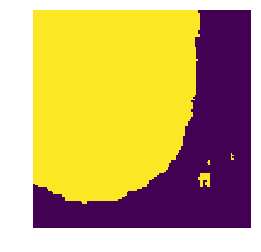

In [166]:
show_img(probs[idx]>0.5);

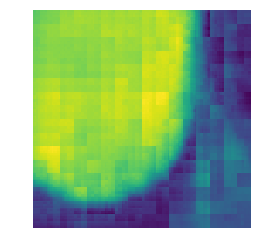

In [167]:
show_img(probs[idx]);

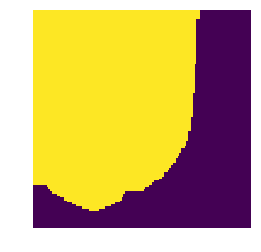

In [169]:
show_img(y[idx]);

# Optimise threshold

In [171]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [172]:
thres = np.linspace(-5, 5, 50)
thres_ioc = [iou_metric_batch(y, np.int32(probs > t)) for t in tqdm_notebook(thres)]

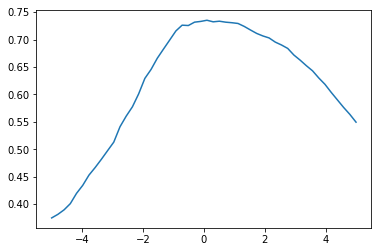

In [173]:
plt.plot(thres, thres_ioc);

In [174]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.1020408163265305, 0.7352500000000001)

In [175]:
thres = np.linspace(-0.5, 0.5, 100)
thres_ioc = [iou_metric_batch(y, np.int32(probs > t)) for t in tqdm_notebook(thres)]

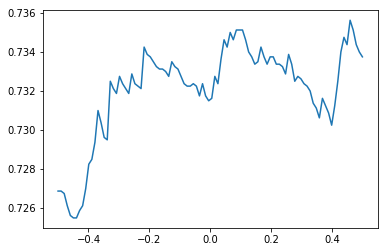

In [176]:
plt.plot(thres, thres_ioc);

In [177]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.45959595959595967, 0.735625)

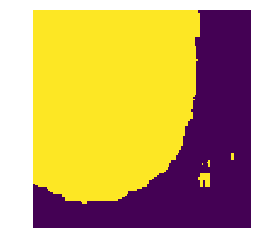

In [178]:
show_img(probs[0]>best_thres);

# Run on test

In [179]:
(PATH/'test-128').mkdir(exist_ok=True)

In [180]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'test-128'/fn.name)

files = list((PATH/'test').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [181]:
testData = np.array(glob(f'{PATH}/test-128/*'))

In [182]:
class TestFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_c(self): return 0

In [183]:
tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(TestFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=testData, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [184]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [185]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [186]:
learn.load('128urn')

In [187]:
x,y = next(iter(md.test_dl))
py = to_np(learn.model(V(x)))

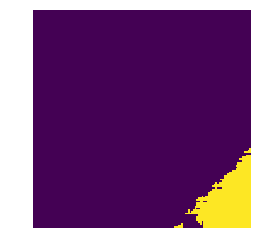

In [188]:
show_img(py[6]>best_thres);

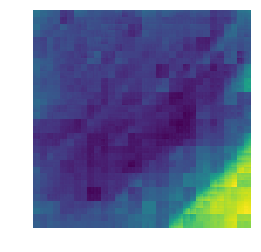

In [189]:
show_img(py[6]);

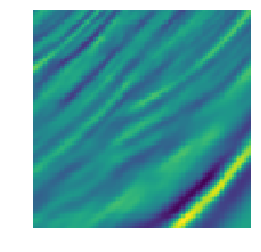

In [190]:
show_img(y[6]);

In [191]:
probs = learn.predict(is_test=True)

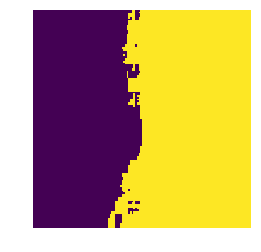

In [192]:
show_img(probs[12]>best_thres);

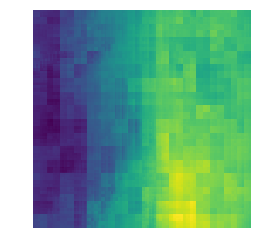

In [193]:
show_img(probs[12]);

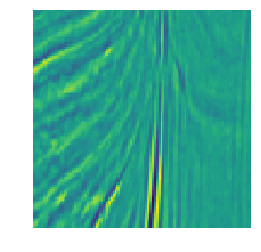

In [194]:
show_img(y[12]);

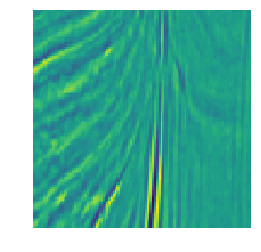

In [195]:
show_img(x[12][0]);

In [196]:
with open(f'{PATH}/probs.pkl', 'wb') as fout: #Save results
    pickle.dump(probs, fout)

In [197]:
probs.shape

(18000, 128, 128)

In [198]:
def resize_img(fn):
    return np.array(Image.fromarray(fn).resize((101,101)))

resizePreds = np.array([resize_img(x) for x in probs])

In [199]:
resizePreds.shape

(18000, 101, 101)

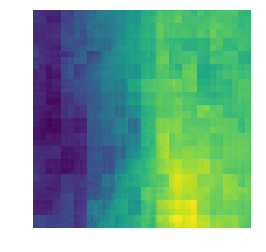

In [200]:
show_img(resizePreds[12]);

In [201]:
testData

array(['/home/giles/Downloads/fastai_data/salt/test-128/ac26efe98e.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/0a5eac8775.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/bdb1c1fcbf.png', ...,
       '/home/giles/Downloads/fastai_data/salt/test-128/3bceaa0303.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/96867a3897.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/52f6267e3f.png'], dtype='<U62')

In [202]:
f'{PATH}/test'

'/home/giles/Downloads/fastai_data/salt/test'

In [203]:
test_ids = next(os.walk(f'{PATH}/test'))[2]

In [204]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [205]:
pred_dict = {id_[:-4]:RLenc(np.round(resizePreds[i] > best_thres)) for i,id_ in tqdm_notebook(enumerate(test_ids))}

In [206]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [207]:
sub

,rle_mask
id,
ac26efe98e,1 34 102 34 203 34 304 34 405 34 506 33 607 37...
0a5eac8775,
bdb1c1fcbf,2254 1 2354 2 2455 2 2758 2 2858 3 2959 3 3059...
5358961921,
b7b72a69d1,
c1169d47ce,
89eb8ef89f,6767 1 6868 1 6968 2 7070 1 7171 1 7271 2 7372...
696d91b37e,
73053e4d03,203 1 613 10 714 10 815 10 916 10 1017 10 1118...
